In [14]:
import numpy as np
import pandas as pd
import cv2
import os
import torch
import json
import time
from sklearn.metrics import mean_squared_error
from mtcnn import MTCNN
import torchvision.ops.boxes as bops
from os import walk

In [20]:
# https://stackoverflow.com/questions/30508922/error-215-empty-in-function-detectmultiscale
# https://realpython.com/traditional-face-detection-python/#haar-like-features
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

def Average(lst):
    if (len(lst)>0):
        return round((sum(lst) / len(lst)),2)
    else:
        return 0

def calculate_precision(TP,FP):
    if(TP+FP) > 0:
        return round(TP/(TP+FP),2)
    else: 
        return 0
    
def calculate_recall(TP,FN):
    if(TP+FN) > 0:
        return round(TP/(TP+FN),2)
    else: 
        return 0

def getEyes(landmarks2D,i): #TOTO treba vyriesiet, rataj to ako pole a appenduj
    
    test = []
    test1 = []
    for y in range(36,42,1):
        try:
            eye = landmarks2D[y,:,i]
            test.append(int(eye[0]))
            test1.append(int(eye[1]))
        except:
            pass
        
    test2 = []
    test3 = []
    for y in range(42,48,1):
        try:
            eye = landmarks2D[y,:,i]
            test2.append(int(eye[0]))
            test3.append(int(eye[1]))
        except:
            pass
    return int(Average(test)),int(Average(test1)),int(Average(test2)),int(Average(test3))
    
    
#     test = 0
#     test1 = 0
#     for y in range(36,42,1): #Lave oko
#         try:
#             eye = landmarks2D[y,:,i]
#             test += int(eye[0])
#             test1 += int(eye[1])
#         except:
#             return 0,0,0,0
    
#     test2 = 0
#     test3 = 0
#     for y in range(42,48,1): #Prave oko
#         try:
#             eye = landmarks2D[y,:,i]
#             test2 += int(eye[0])
#             test3 += int(eye[1])
#         except:
#             return 0,0,0,0
    
#     return int(test/6), int(test1/6), int(test2/6), int(test3/6)


def getEyesSquares(landmarks2D,i):
    try:
        left1,left2,right1,right2 = getEyes(landmarks2D,i)

        eye4 = landmarks2D[37,:,i]
        eye5 = landmarks2D[40,:,i]

        result = int(((((eye5[0] - eye4[0] )**2) + ((eye5[1]-eye4[1])**2) )**0.5)*2) #Vzdielenost dvoj najviac vzdialenych bodov v oku

        eye4 = landmarks2D[43,:,i]
        eye5 = landmarks2D[46,:,i]

        result2 = int(((((eye5[0] - eye4[0] )**2) + ((eye5[1]-eye4[1])**2) )**0.5)*2)

        return left1+result,left2+result,left1-result,left2-result,right1+result2,right2+result2,right1-result2,right2-result2
    except:
        return 0,0,0,0,0,0,0,0

def calculateMSE(keypoints,landmarks2D,i):
    left1,left2,right1,right2 = getEyes(landmarks2D,i)
    Y_true = []
    Y_pred = []
    Y_true.append(left1)
    Y_true.append(left2)
    Y_true.append(right1)
    Y_true.append(right2)
    left1,left2 = keypoints['left_eye']
    right1,right2 = keypoints['right_eye']
    Y_pred.append(left1)
    Y_pred.append(left2)
    Y_pred.append(right1)
    Y_pred.append(right2)
    return mean_squared_error(Y_true,Y_pred)
    
def calculateMSEsquares(one1,one2,one3,one4,two1,two2,two3,two4):
    Y_true = []
    Y_pred = []
    Y_true.append(one1)
    Y_true.append(one2)
    Y_true.append(one3)
    Y_true.append(one4)
    Y_pred.append(two1)
    Y_pred.append(two2)
    Y_pred.append(two3)
    Y_pred.append(two4)
    return mean_squared_error(Y_true,Y_pred)
    
    


    

In [31]:
folderName = 'viz_vzorka'
filenames = next(walk(folderName), (None, None, []))[2]  # https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
filenames = [folderName + '/' + s for s in filenames] #https://stackoverflow.com/questions/2050637/appending-the-same-string-to-a-list-of-strings-in-python


for filename in filenames:
    videoFile = np.load(filename)
    colorImages =  videoFile['colorImages_original']
    colorImagesMedium = videoFile['colorImages_medium']
    colorImagesSevere = videoFile['colorImages_severe']
    boundingBox = videoFile['boundingBox']
    landmarks2D = videoFile['landmarks2D']

    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    h, w, d, numberOfFrames = colorImages.shape 
    name = "test/" + filename[:len(filename) - 4] + '.avi'
    out = cv2.VideoWriter(name,fourcc,10, (w * 4, h))
    for i in range(numberOfFrames):
        img0 = np.zeros((h,w,d),np.uint8)
        
        start_point = (int(boundingBox[0][0][i]),int(boundingBox[0][1][i]))
        end_point = (int(boundingBox[2][0][i]),int(boundingBox[3][1][i])) #kreslim stvorec tvare
        img0 = cv2.rectangle(img0,start_point,end_point,(0,255,0))
        
        for one in landmarks2D:
            img0 = cv2.circle(img0,(int(one[0,i]),int(one[1,i])),radius = 0, color=(255,255,255), thickness=-1) #kreslim body tvare
        
#         Zakreslujem stredy oci podla 6 bodov
        left1,left2,right1,right2 = getEyes(landmarks2D,i)
        img0 = cv2.circle(img0,(left1,left2),radius = 2, color=(255,0,0), thickness=2) #kreslim body tvare
        img0 = cv2.circle(img0,(right1,right2),radius = 2, color=(0,255,0), thickness=2) #kreslim body tvare
       
        img1 = cv2.cvtColor(colorImages[:, :, :, i],cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(colorImagesMedium[:, :, :, i],cv2.COLOR_BGR2RGB)
        img3 = cv2.cvtColor(colorImagesSevere[:, :, :, i],cv2.COLOR_BGR2RGB)
        
        oneForAll = np.hstack((img0,img1,img2,img3))
        out.write(oneForAll)
    out.release()


In [50]:
# IoU https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation

# VIOLA-JONES

folderName = 'viz_vzorka'
filenames = next(walk(folderName), (None, None, []))[2]  # https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
filenames = [folderName + '/' + s for s in filenames] #https://stackoverflow.com/questions/2050637/appending-the-same-string-to-a-list-of-strings-in-python

start_time = time.time()
threshold = 0.5
statistics = []

for filename in filenames:
    MSE = []
    MSEmedium = []
    MSEsevere = []
    
    videoFile = np.load(filename)
    colorImages =  videoFile['colorImages_original']
    colorImagesMedium = videoFile['colorImages_medium']
    colorImagesSevere = videoFile['colorImages_severe']
    boundingBox = videoFile['boundingBox']
    
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    h, w, d, numberOfFrames = colorImages.shape 
    name = "viola-jones/" + filename[:len(filename) - 4] + '.avi'
    out = cv2.VideoWriter(name,fourcc,10, (w * 3, h))
    TP, TPmedium, TPsevere = 0, 0, 0
    FP, FPmedium, FPsevere = 0, 0, 0
    FN, FNmedium, FNsevere = 0, 0, 0
    for i in range(numberOfFrames):
        
        boxToFind = torch.tensor([[boundingBox[0][0][i],boundingBox[0][1][i],boundingBox[2][0][i],boundingBox[3][1][i]]], dtype=torch.float)     
        left1,left2,left3,left4,right1,right2,right3,right4 = getEyesSquares(landmarks2D,i)

        
        
        img1 = cv2.cvtColor(colorImages[:, :, :, i],cv2.COLOR_BGR2RGB)
        detected_faces1 = face_cascade.detectMultiScale(img1)
        detected_eyes1 = eye_cascade.detectMultiScale(img1)
        
        for (column,row,width,height) in detected_faces1:
            cv2.rectangle(img1,(column,row),(column+width,row+width),(0,255,0),2)
            boxFound = torch.tensor([[column,row,column+width,row+width]], dtype=torch.float)
            iou = bops.box_iou(boxFound,boxToFind)
            iou = round(iou.numpy()[0][0],2)
            if iou >= threshold:
                TP += 1
            else:
                FP += 1
        if detected_faces1 is None:
            FN += 1
       
#         Oci netreba, ale je to krajsie
        for (column,row,width,height) in detected_eyes1:
            MSEleft = calculateMSEsquares(left1,left2,left3,left4,column,row,column+width,row+width)
            MSEright = calculateMSEsquares(right1,right2,right3,right4,column,row,column+width,row+width)
            if(MSEleft>MSEright):
                MSE.append(MSEright)
            else:
                MSE.append(MSEleft)
                
            cv2.rectangle(img1,(column,row),(column+width,row+width),(0,0,255),2)
# 
        
        img2 = cv2.cvtColor(colorImagesMedium[:, :, :, i],cv2.COLOR_BGR2RGB)
        detected_faces2 = face_cascade.detectMultiScale(img2)
        detected_eyes2 = eye_cascade.detectMultiScale(img2)
        for (column,row,width,height) in detected_faces2:
            cv2.rectangle(img2,(column,row),(column+width,row+width),(0,255,0),2)
            boxFound = torch.tensor([[column,row,column+width,row+width]], dtype=torch.float)
            iou = bops.box_iou(boxFound,boxToFind)
            iou = round(iou.numpy()[0][0],2)
            if iou >= threshold:
                TPmedium += 1
            else:
                FPmedium += 1
        if detected_faces2 is None:
            FNmedium += 1
            
        

#         Oci netreba, ale je to krajsie
        for (column,row,width,height) in detected_eyes2:
            MSEleft = calculateMSEsquares(left1,left2,left3,left4,column,row,column+width,row+width)
            MSEright = calculateMSEsquares(right1,right2,right3,right4,column,row,column+width,row+width)
            if(MSEleft>MSEright):
                MSEmedium.append(MSEright)
            else:
                MSEmedium.append(MSEleft)
            cv2.rectangle(img2,(column,row),(column+width,row+width),(0,0,255),2)
# 

        img3 = cv2.cvtColor(colorImagesSevere[:, :, :, i],cv2.COLOR_BGR2RGB)
        detected_faces3 = face_cascade.detectMultiScale(img3)
        detected_eyes3 = eye_cascade.detectMultiScale(img3)
        for (column,row,width,height) in detected_faces3:
            cv2.rectangle(img3,(column,row),(column+width,row+width),(0,255,0),2)
            boxFound = torch.tensor([[column,row,column+width,row+width]], dtype=torch.float)
            iou = bops.box_iou(boxFound,boxToFind)
            iou = round(iou.numpy()[0][0],2)
            if iou >= threshold:
                TPsevere += 1
            else:
                FPsevere += 1
        if detected_faces3 is None:
            FNsevere += 1
             
#         Oci netreba, ale je to krajsie
        for (column,row,width,height) in detected_eyes3:
            MSEleft = calculateMSEsquares(left1,left2,left3,left4,column,row,column+width,row+width)
            MSEright = calculateMSEsquares(right1,right2,right3,right4,column,row,column+width,row+width)
            if(MSEleft>MSEright):
                MSEsevere.append(MSEright)
            else:
                MSEsevere.append(MSEleft)
            cv2.rectangle(img3,(column,row),(column+width,row+width),(0,0,255),2)
            
        oneForAll = np.hstack((img1,img2,img3))
        out.write(oneForAll)
        
    statistics.append([filename, calculate_precision(TP,FP), calculate_recall(TP,FN), Average(MSE),
                       calculate_precision(TPmedium,FPmedium), calculate_recall(TPmedium,FNmedium), Average(MSEmedium),
                       calculate_precision(TPsevere,FPsevere), calculate_recall(TPsevere,FNsevere),Average(MSEsevere)])
    out.release()
    
print("--- %s seconds ---" % (time.time() - start_time))   

DF = pd.DataFrame(statistics)
DF.columns=['filename','precision_normal','recall_normal','MSE(eyes)_average','precision_medium','recall_medium','MSE(eyes)_medium_average','precision_severe','recall_severe','MSE(eyes)_medium_severe']
DF.to_csv("viz_vzorka_VIOLA-JONES.csv")


--- 50.9870285987854 seconds ---


In [51]:
# MTCNN

folderName = 'viz_vzorka'
filenames = next(walk(folderName), (None, None, []))[2]  # https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
filenames = [folderName + '/' + s for s in filenames] #https://stackoverflow.com/questions/2050637/appending-the-same-string-to-a-list-of-strings-in-python

start_time = time.time()
threshold = 0.5
statistics = []
detector = MTCNN()


for filename in filenames:
    MSE = []
    MSEmedium = []
    MSEsevere = []
    
    videoFile = np.load(filename)
    colorImages =  videoFile['colorImages_original']
    colorImagesMedium = videoFile['colorImages_medium']
    colorImagesSevere = videoFile['colorImages_severe']
    boundingBox = videoFile['boundingBox']
    landmarks2D = videoFile['landmarks2D']
    
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    h, w, d, numberOfFrames = colorImages.shape 
    name = "cnn/" + filename[:len(filename) - 4] + '.avi'
    out = cv2.VideoWriter(name,fourcc,10, (w * 3, h))
    TP, TPmedium, TPsevere = 0, 0, 0
    FP, FPmedium, FPsevere = 0, 0, 0
    FN, FNmedium, FNsevere = 0, 0, 0
    for i in range(numberOfFrames):
        boxToFind = torch.tensor([[boundingBox[0][0][i],boundingBox[0][1][i],boundingBox[2][0][i],boundingBox[3][1][i]]], dtype=torch.float)
        
        img1 = cv2.cvtColor(colorImages[:, :, :, i],cv2.COLOR_BGR2RGB)
        
        
        detected_faces = detector.detect_faces(img1)
        for det in detected_faces:
            if(det['confidence']>=0.9):
                box = det['box']
                keypoints = det['keypoints']
                if box is not None:
                    cv2.rectangle(img1,(box[0],box[1]),(box[0]+box[2],box[1]+box[3]),(0,255,0),2)
                    boxFound = torch.tensor([[box[0],box[1],box[0]+box[2],box[1]+box[3]]], dtype=torch.float)
                    iou = bops.box_iou(boxFound,boxToFind)
                    iou = round(iou.numpy()[0][0],2)
                    if iou >= threshold:
                        TP += 1
                    else:
                        FP += 1
                else:
                    FN += 1

                cv2.circle(img1,(keypoints['left_eye']), 2, (0,155,255), 2)
                cv2.circle(img1,(keypoints['right_eye']), 2, (0,155,255), 2)
                cv2.circle(img1,(keypoints['nose']), 2, (0,155,255), 2)
                cv2.circle(img1,(keypoints['mouth_left']), 2, (0,155,255), 2)
                cv2.circle(img1,(keypoints['mouth_right']), 2, (0,155,255), 2)
                MSE.append(calculateMSE(keypoints,landmarks2D,i))
            else:
                FN +=1

                    
            
        img2 = cv2.cvtColor(colorImagesMedium[:, :, :, i],cv2.COLOR_BGR2RGB)
        
        detected_faces = detector.detect_faces(img2)
                
        for det in detected_faces:
            if(det['confidence']>=0.9):
                box = det['box']
                keypoints = det['keypoints']
                if box is not None:
                    cv2.rectangle(img2,(box[0],box[1]),(box[0]+box[2],box[1]+box[3]),(0,255,0),2)
                    boxFound = torch.tensor([[box[0],box[1],box[0]+box[2],box[1]+box[3]]], dtype=torch.float)
                    iou = bops.box_iou(boxFound,boxToFind)
                    iou = round(iou.numpy()[0][0],2)
                    if iou >= threshold:
                        TPmedium += 1
                    else:
                        FPmedium += 1
                else:
                    FNmedium += 1
                    
                cv2.circle(img2,(keypoints['left_eye']), 2, (0,155,255), 2)
                cv2.circle(img2,(keypoints['right_eye']), 2, (0,155,255), 2)
                cv2.circle(img2,(keypoints['nose']), 2, (0,155,255), 2)
                cv2.circle(img2,(keypoints['mouth_left']), 2, (0,155,255), 2)
                cv2.circle(img2,(keypoints['mouth_right']), 2, (0,155,255), 2)
                MSEmedium.append(calculateMSE(keypoints,landmarks2D,i))
            else:
                FNmedium += 1
        
        
            
        
        img3 = cv2.cvtColor(colorImagesSevere[:, :, :, i],cv2.COLOR_BGR2RGB)
        detected_faces = detector.detect_faces(img3)

        
        for det in detected_faces:
            if(det['confidence']>=0.9):
                box = det['box']
                keypoints = det['keypoints']
                if box is not None:
                    cv2.rectangle(img3,(box[0],box[1]),(box[0]+box[2],box[1]+box[3]),(0,255,0),2)
                    boxFound = torch.tensor([[box[0],box[1],box[0]+box[2],box[1]+box[3]]], dtype=torch.float)
                    iou = bops.box_iou(boxFound,boxToFind)
                    iou = round(iou.numpy()[0][0],2)
                    if iou >= threshold:
                        TPsevere += 1
                    else:
                        FPsevere += 1
                else:
                    FNsevere += 1
                    
                cv2.circle(img3,(keypoints['left_eye']), 2, (0,155,255), 2)
                cv2.circle(img3,(keypoints['right_eye']), 2, (0,155,255), 2)
                cv2.circle(img3,(keypoints['nose']), 2, (0,155,255), 2)
                cv2.circle(img3,(keypoints['mouth_left']), 2, (0,155,255), 2)
                cv2.circle(img3,(keypoints['mouth_right']), 2, (0,155,255), 2)
                MSEsevere.append(calculateMSE(keypoints,landmarks2D,i))
            else:
                FNsevere += 1


            
        oneForAll = np.hstack((img1,img2,img3))
        out.write(oneForAll)
    
    statistics.append([filename, calculate_precision(TP,FP), calculate_recall(TP,FN), Average(MSE),
                       calculate_precision(TPmedium,FPmedium), calculate_recall(TPmedium,FNmedium), Average(MSEmedium),
                       calculate_precision(TPsevere,FPsevere), calculate_recall(TPsevere,FNsevere),Average(MSEsevere)])
    out.release()
    
print("--- %s seconds ---" % (time.time() - start_time)) 

DF = pd.DataFrame(statistics)
DF.columns=['filename','precision_normal','recall_normal','MSE(eyes)_average','precision_medium','recall_medium','MSE(eyes)_medium_average','precision_severe','recall_severe','MSE(eyes)_medium_severe']
DF.to_csv("viz_vzorka_MTCNN.csv")

--- 850.439722776413 seconds ---


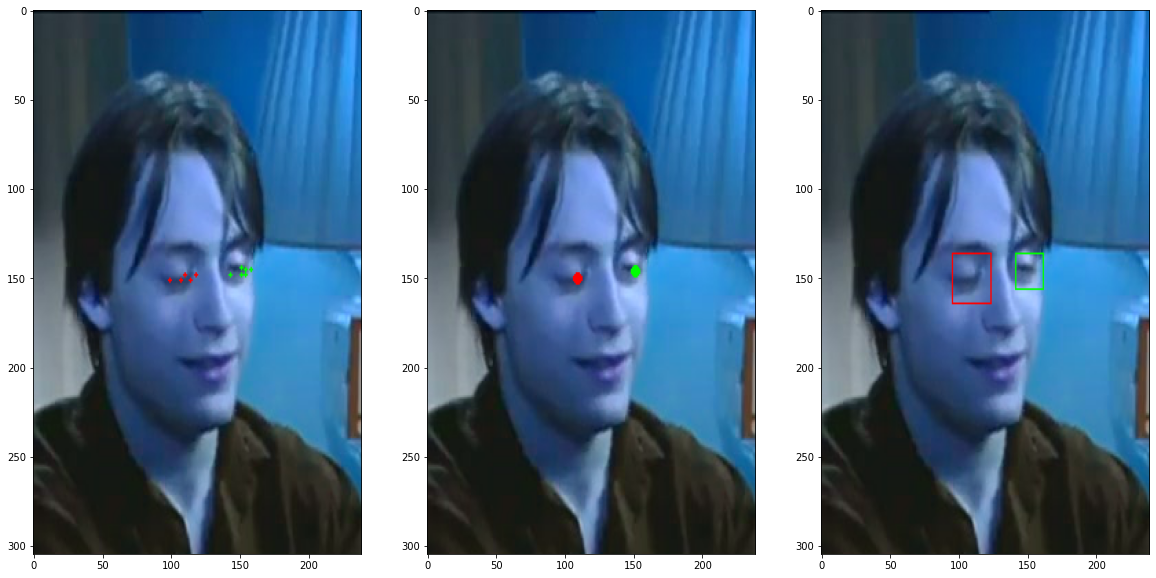

In [32]:
from matplotlib import pyplot as plt

f, axarr = plt.subplots(1,3,figsize=(20,10))
i=0

videoFile = np.load(filenames[i])
colorImages =  videoFile['colorImages_original']
img1 = cv2.cvtColor(colorImages[:, :, :, i],cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(colorImages[:, :, :, i],cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(colorImages[:, :, :, i],cv2.COLOR_BGR2RGB)

boundingBox = videoFile['boundingBox']
landmarks2D = videoFile['landmarks2D']

for y in range(36,42,1): #Lave oko
    eye = landmarks2D[y,:,i]
    img1 = cv2.circle(img1,((int(eye[0]),int(eye[1]))),radius = 1, color=(255,0,0), thickness=-1) #kreslim body tvare
    
for y in range(42,48,1): #Prave oko
    eye = landmarks2D[y,:,i]
    img1 = cv2.circle(img1,((int(eye[0]),int(eye[1]))),radius = 1, color=(0,255,0), thickness=-1) #kreslim body tvare

left1,left2,right1,right2 = getEyes(landmarks2D,i)

img2 = cv2.circle(img2,(left1,left2),radius = 2, color=(255,0,0), thickness=2) #kreslim body tvare
img2 = cv2.circle(img2,(right1,right2),radius = 2, color=(0,255,0), thickness=2) #kreslim body tvare

left1,left2,left3,left4,right1,right2,right3,right4 = getEyesSquares(landmarks2D,i)

img3 = cv2.rectangle(img3,(left1,left2),(left3,left4),(255,0,0))
img3 = cv2.rectangle(img3,(right1,right2),(right3,right4),(0,255,0))

    
axarr[0].imshow(img1,aspect='auto')
axarr[1].imshow(img2,aspect='auto')
axarr[2].imshow(img3,aspect='auto')

plt.show()


In [52]:
# IoU https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation

# VIOLA-JONES

folderName = 'videos-K-O'
filenames = next(walk(folderName), (None, None, []))[2]  # https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
filenames = [folderName + '/' + s for s in filenames] #https://stackoverflow.com/questions/2050637/appending-the-same-string-to-a-list-of-strings-in-python

start_time = time.time()
threshold = 0.5
statistics = []

for filename in filenames:

    MSE = []

    videoFile = np.load(filename)
    colorImages =  videoFile['colorImages']
    boundingBox = videoFile['boundingBox']
    
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    h, w, d, numberOfFrames = colorImages.shape 
    name = "viola-jones/" + filename[:len(filename) - 4] + '.avi'
    out = cv2.VideoWriter(name,fourcc,10, (w, h))
    TP, FP, FN = 0,0,0
    for i in range(numberOfFrames):
        
        boxToFind = torch.tensor([[boundingBox[0][0][i],boundingBox[0][1][i],boundingBox[2][0][i],boundingBox[3][1][i]]], dtype=torch.float)     
        left1,left2,left3,left4,right1,right2,right3,right4 = getEyesSquares(landmarks2D,i)

        
        img1 = cv2.cvtColor(colorImages[:, :, :, i],cv2.COLOR_BGR2RGB)
        detected_faces1 = face_cascade.detectMultiScale(img1)
        detected_eyes1 = eye_cascade.detectMultiScale(img1)
        
        for (column,row,width,height) in detected_faces1:
            cv2.rectangle(img1,(column,row),(column+width,row+width),(0,255,0),2)
            boxFound = torch.tensor([[column,row,column+width,row+width]], dtype=torch.float)
            iou = bops.box_iou(boxFound,boxToFind)
            iou = round(iou.numpy()[0][0],2)
            if iou >= threshold:
                TP += 1
            else:
                FP += 1
        if detected_faces1 is None:
            FN += 1
       
#         Oci netreba, ale je to krajsie
        for (column,row,width,height) in detected_eyes1:
            MSEleft = calculateMSEsquares(left1,left2,left3,left4,column,row,column+width,row+width)
            MSEright = calculateMSEsquares(right1,right2,right3,right4,column,row,column+width,row+width)
            if(MSEleft>MSEright):
                MSE.append(MSEright)
            else:
                MSE.append(MSEleft)
                
            cv2.rectangle(img1,(column,row),(column+width,row+width),(0,0,255),2)

            
        out.write(img1)
        
    statistics.append([filename, calculate_precision(TP,FP), calculate_recall(TP,FN), Average(MSE)])
    
    out.release()
    
print("--- %s seconds ---" % (time.time() - start_time))   

DF = pd.DataFrame(statistics)
DF.columns=['filename','precision_normal','recall_normal','MSE(eyes)_average']
DF.to_csv("videos-K-O_VIOLA-JONES.csv")


--- 916.0622315406799 seconds ---


In [53]:
# MTCNN

folderName = 'videos-K-O'
filenames = next(walk(folderName), (None, None, []))[2]  # https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
filenames = [folderName + '/' + s for s in filenames] #https://stackoverflow.com/questions/2050637/appending-the-same-string-to-a-list-of-strings-in-python

start_time = time.time()
threshold = 0.5
statistics = []
detector = MTCNN()


for filename in filenames:

    MSE = []
    
    videoFile = np.load(filename)
    colorImages =  videoFile['colorImages']
    boundingBox = videoFile['boundingBox']
    landmarks2D = videoFile['landmarks2D']
    
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    h, w, d, numberOfFrames = colorImages.shape 
    name = "cnn/" + filename[:len(filename) - 4] + '.avi'
    out = cv2.VideoWriter(name,fourcc,10, (w, h))
    TP, FP, FN = 0, 0, 0

    for i in range(numberOfFrames):
        boxToFind = torch.tensor([[boundingBox[0][0][i],boundingBox[0][1][i],boundingBox[2][0][i],boundingBox[3][1][i]]], dtype=torch.float)
        
        img1 = cv2.cvtColor(colorImages[:, :, :, i],cv2.COLOR_BGR2RGB)
        
        
        detected_faces = detector.detect_faces(img1)
        for det in detected_faces:
            if(det['confidence']>=0.9):
                box = det['box']
                keypoints = det['keypoints']
                if box is not None:
                    cv2.rectangle(img1,(box[0],box[1]),(box[0]+box[2],box[1]+box[3]),(0,255,0),2)
                    boxFound = torch.tensor([[box[0],box[1],box[0]+box[2],box[1]+box[3]]], dtype=torch.float)
                    iou = bops.box_iou(boxFound,boxToFind)
                    iou = round(iou.numpy()[0][0],2)
                    if iou >= threshold:
                        TP += 1
                    else:
                        FP += 1
                else:
                    FN += 1

                cv2.circle(img1,(keypoints['left_eye']), 2, (0,155,255), 2)
                cv2.circle(img1,(keypoints['right_eye']), 2, (0,155,255), 2)
                cv2.circle(img1,(keypoints['nose']), 2, (0,155,255), 2)
                cv2.circle(img1,(keypoints['mouth_left']), 2, (0,155,255), 2)
                cv2.circle(img1,(keypoints['mouth_right']), 2, (0,155,255), 2)
                MSE.append(calculateMSE(keypoints,landmarks2D,i))
            else:
                FN +=1
          
        out.write(img1)
    
    statistics.append([filename, calculate_precision(TP,FP), calculate_recall(TP,FN), Average(MSE)])
    out.release()
    
print("--- %s seconds ---" % (time.time() - start_time)) 

DF = pd.DataFrame(statistics)
DF.columns=['filename','precision_normal','recall_normal','MSE(eyes)_average']
DF.to_csv("videos-K-O_MTCNN.csv")

--- 16741.71516561508 seconds ---


In [28]:
# https://www.geeksforgeeks.org/python-opencv-capture-video-from-camera/
# MTCNN camera face

vid = cv2.VideoCapture(0)

detector = MTCNN()
  
while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
  
    # Display the resulting frame
    
    img1 = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    detected_faces = detector.detect_faces(img1)
    for det in detected_faces:
            if(det['confidence']>=0.9):
                box = det['box']
                keypoints = det['keypoints']
                cv2.rectangle(frame,(box[0],box[1]),(box[0]+box[2],box[1]+box[3]),(0,255,0),2)
                cv2.circle(frame,(keypoints['left_eye']), 2, (0,155,255), 2)
                cv2.circle(frame,(keypoints['right_eye']), 2, (0,155,255), 2)
                cv2.circle(frame,(keypoints['nose']), 2, (0,155,255), 2)
                cv2.circle(frame,(keypoints['mouth_left']), 2, (0,155,255), 2)
                cv2.circle(frame,(keypoints['mouth_right']), 2, (0,155,255), 2)              
    cv2.imshow('frame', frame)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

In [21]:
# VIOLA JONES camera face

vid = cv2.VideoCapture(0)
detector = MTCNN()
  
while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
  
    # Display the resulting frame
    
    img1 = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    
    detected_faces1 = face_cascade.detectMultiScale(img1)
    detected_eyes1 = eye_cascade.detectMultiScale(img1)
        
    for (column,row,width,height) in detected_faces1:
        cv2.rectangle(frame,(column,row),(column+width,row+width),(0,255,0),2)

    for (column,row,width,height) in detected_eyes1:
        cv2.rectangle(frame,(column,row),(column+width,row+width),(0,0,255),2)
        
    cv2.imshow('frame', frame)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()